In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    poutres_path = os.path.join(base_dir, f"maquette{i}", f"poutres{i}.csv")
    if os.path.exists(poutres_path):
        with open(poutres_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(poutres_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {poutres_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {poutres_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {poutres_path}")

if dfs:
    poutres_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {poutres_concat.shape[0]} lignes, {poutres_concat.shape[1]} colonnes")
else:
    poutres_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

poutres_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/poutres1.csv (778 lignes, 136 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  822465        GO        POUTRE          INTERIEUR         PREFA CHANTIER   
1  822610        GO        POUTRE          INTERIEUR         PREFA CHANTIER   
2  823043        GO   BANDE NOYEE            COURANT         COULE EN PLACE   
3  823110        GO   BANDE NOYEE            COURANT         COULE EN PLACE   
4  823289        GO   BANDE NOYEE            COURANT         COULE EN PLACE   

       Nom                  AI                 AS Hauteur totale  \
0  30x60ht  -0,200000000000001  0,200000000000001            0,6   
1  25x50ht  -0,150000000000001  0,150000000000001            0,5   
2  30x20ht                -0,1                0,1            0,2   
3  30x20ht                -0,1                0,1            0,2   
4  30x20ht                -0,1                0,1            0,2   

  

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,AI,AS,Hauteur totale,Hauteur,...,Largeur du noyau,Décalage d'alvéole,Nombre d'alvéoles,Hauteur du noyau,D2,D3,D4,D5,Retombé,Hauteur Poutre
0,822465,GO,POUTRE,INTERIEUR,PREFA CHANTIER,30x60ht,"-0,200000000000001","0,200000000000001","0,6","0,400000000000002",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822610,GO,POUTRE,INTERIEUR,PREFA CHANTIER,25x50ht,"-0,150000000000001","0,150000000000001","0,5","0,300000000000002",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,823043,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,823110,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,823289,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
poutres_concat.shape

(20727, 529)

In [4]:
print(poutres_concat)

            Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation  \
0       822465        GO        POUTRE          INTERIEUR   
1       822610        GO        POUTRE          INTERIEUR   
2       823043        GO   BANDE NOYEE            COURANT   
3       823110        GO   BANDE NOYEE            COURANT   
4       823289        GO   BANDE NOYEE            COURANT   
...        ...       ...           ...                ...   
20722  4543660        GO   BANDE NOYEE            COURANT   
20723  4546571        GO   BANDE NOYEE            COURANT   
20724  4546572        GO   BANDE NOYEE            COURANT   
20725  4548917        GO        POUTRE            COURANT   
20726  4549419        GO        POUTRE            COURANT   

      014EC_Mode Constructif                   Nom                  AI  \
0             PREFA CHANTIER               30x60ht  -0,200000000000001   
1             PREFA CHANTIER               25x50ht  -0,150000000000001   
2             COULE EN PLACE               30

In [5]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type",
    "Nom"
]

# On ne garde que les colonnes présentes dans le DataFrame
poutres_concat = poutres_concat[[col for col in colonnes_a_garder if col in poutres_concat.columns]]

In [6]:
print(poutres_concat.columns.tolist())

['011EC_Lot', '012EC_Ouvrage', '013EC_Localisation', '014EC_Mode Constructif', 'Sols en intersection', 'Sols coupés (u)', 'Sols coupants (u)', 'Sol au-dessus', 'Sol en-dessous', 'Matériau structurel', 'Famille et type', 'Nom']


In [7]:
poutres_concat

,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Sols en intersection,Sols coupés (u),Sols coupants (u),Sol au-dessus,Sol en-dessous,Matériau structurel,Famille et type,Nom
0,GO,POUTRE,INTERIEUR,PREFA CHANTIER,0,0,1,False,False,Béton - Béton précoulé,Poutre rectangulaire: 30x60ht,30x60ht
1,GO,POUTRE,INTERIEUR,PREFA CHANTIER,0,0,1,False,False,Béton - Béton précoulé,Poutre rectangulaire: 25x50ht,25x50ht
2,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,1,0,False,False,Béton - Béton précoulé,Bande noyée: 30x20ht,30x20ht
3,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,1,0,False,False,Béton - Béton précoulé,Bande noyée: 30x20ht,30x20ht
4,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,1,0,False,False,Béton - Béton précoulé,Bande noyée: 30x20ht,30x20ht
...,...,...,...,...,...,...,...,...,...,...,...,...
20722,GO,BANDE NOYEE,COURANT,COULE EN PLACE,1,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_BN10_30x27,ECDA_RDC_BN10_30x27
20723,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_BN2_30x27,ECDA_RDC_BN2_30x27
20724,GO,BANDE NOYEE,COURANT,COULE EN PLACE,0,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_BN2_30x27,ECDA_RDC_BN2_30x27
20725,GO,POUTRE,COURANT,PREFA CHANTIER,1,0,0,False,False,BÉTON,A_OSS_POUTRE_RECTANGULAIRE: ECDA_RDC_PO_08_40x65,ECDA_RDC_PO_08_40x65


In [8]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

poutres_concat.columns = [clean_col(c) for c in poutres_concat.columns]
print(poutres_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'materiau_structurel', 'famille_et_type', 'nom']


In [9]:
# Définir les targets multi-label (adapte la liste selon tes besoins)
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in poutres_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans murs_concat. Colonnes disponibles : {poutres_concat.columns.tolist()}")

# X et y_multi
X = poutres_concat.drop(columns=targets_in_df)
y_multi = poutres_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(RandomForestClassifier(n_estimators=5000, random_state=42)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction et score baseline
y_pred = pipeline.predict(X_test)
print("Accuracy moyenne multi-label :", (y_pred == y_test.values).mean())

Accuracy moyenne multi-label : 0.968463462072798


In [10]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 3599 échantillons.


In [11]:
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9685
F1 macro (moyenne par cible): 0.9340


In [12]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
2      013ec_localisation  0.798070
3  014ec_mode_constructif  0.959496
1           012ec_ouvrage  0.978298
0               011ec_lot  1.000000


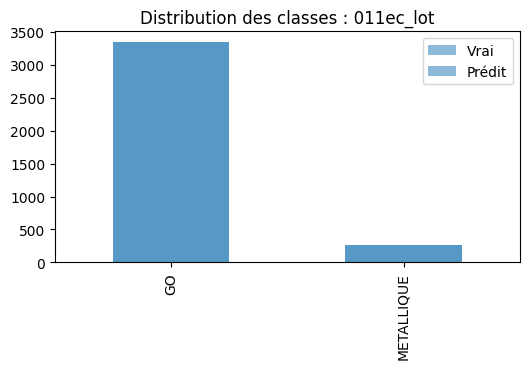

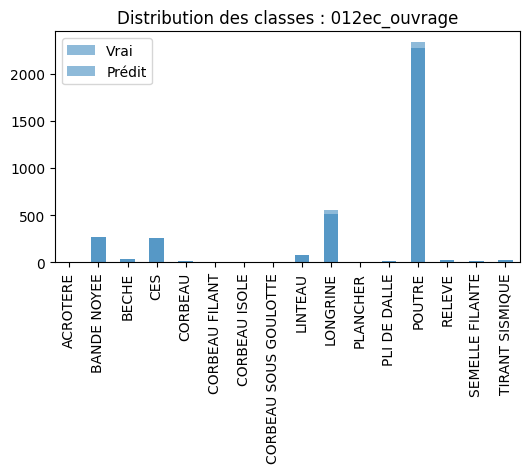

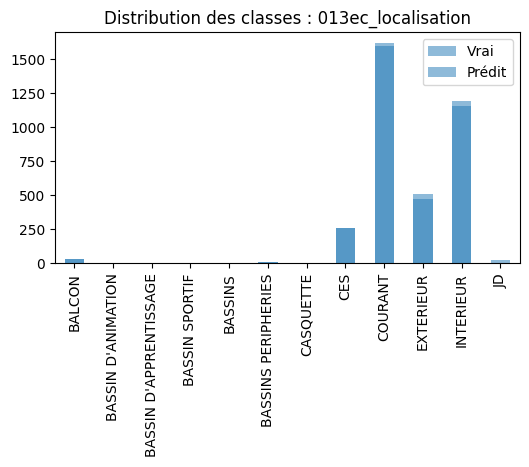

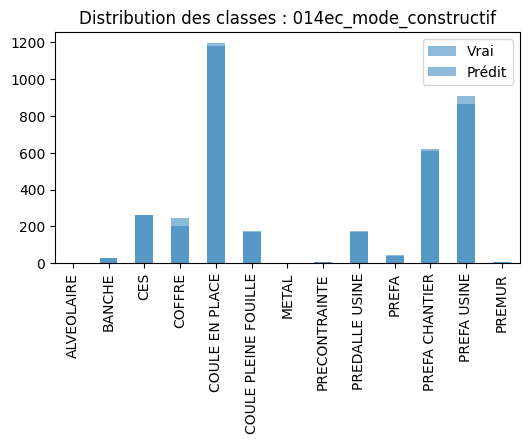

In [13]:
import matplotlib.pyplot as plt

for i, col in enumerate(y_test.columns):
    plt.figure(figsize=(6,3))
    pd.Series(y_test.iloc[:, i]).value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Vrai')
    pd.Series(y_pred[:, i]).value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Prédit')
    plt.title(f"Distribution des classes : {col}")
    plt.legend()
    plt.show()